## Test notebook for Data Management Acceptance Test Campaign 1
This test will be executed on the Rubin Science Platform Notebook Aspect at the Interim Data Facility, initialized with Science Pipelines release w_2022_32.

### Test case LVV-T129: Verify implementation of Provide Calibrated Photometry

Verify that the DMS provides photometry calibrated in AB mags and fluxes (in nJy) for all measured objects and sources. Must be tested for both DRP and AP products.

In [1]:
from IPython.display import Markdown as md

from lsst.rsp import get_tap_service, retrieve_query
    
service = get_tap_service()

md(f'The service endpoint for TAP in this environment is:\n\n &#10145;&nbsp;&nbsp;   {service.baseurl}')

The service endpoint for TAP in this environment is:

 &#10145;&nbsp;&nbsp;   https://data.lsst.cloud/api/tap

#### Extract a small amount of data from the Object table:

In [2]:
results = service.search("SELECT coord_ra, coord_dec, g_cModelFlux, r_cModelFlux, g_psfFlux \
                          FROM dp02_dc2_catalogs.Object \
                          WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), \
                          CIRCLE('ICRS', 60.0, -30.0, 0.05)) = 1")

#### Examine the table to confirm that fluxes are calibrated to nJy

In [3]:
results.to_table()[:10]

coord_ra,coord_dec,g_cModelFlux,r_cModelFlux,g_psfFlux
deg,deg,nJy,nJy,nJy
float64,float64,float64,float64,float64
59.9987401,-29.9728812,62.7060123,49.3496319,54.6548462
59.9995813,-29.9743232,166.0433743,394.8261645,136.6921604
59.9989853,-29.9750457,78.9557388,85.2691232,78.6389713
59.9993731,-29.9732406,111.0082072,165.6229656,69.8171469
60.0477786,-29.9736805,68.4818592,49.4783714,59.2483406
60.0400024,-29.9731507,52.0567337,114.2562171,42.9333247
60.0054666,-29.9728639,146.053072,134.1795803,128.0482605
60.00489,-29.9732239,1436.7150639,3606.8163133,1235.7175275


The second line of the above table confirms that all fluxes for the subset of columns extracted are in nanoJanskys; thus the requirement is met.

The following cell demonstrates that these fluxes can be converted to AB magnitudes using Astropy unit conversions.

In [4]:
import astropy.units as u

fluxes_njy = results['r_cModelFlux'][:10]*u.nJy
print(fluxes_njy.to(u.ABmag))

[27.16679021 24.90898519 26.57302051 25.85219861 27.16396151 26.2553004
 26.08078393 22.50718994 27.01857718 26.58137839] mag(AB)


#### Extract a small amount of data from the DIAObject table:

In [5]:
results = service.search("SELECT ra, decl, nDiaSources, \
                          gPSFluxMean, gPSFluxSigma, gTOTFluxMean \
                          FROM dp02_dc2_catalogs.DiaObject as obj \
                          WHERE CONTAINS(POINT('ICRS', ra, decl), \
                          CIRCLE('ICRS', 60.0, -30.0, 0.05)) = 1")


In [6]:
results.to_table()[0:10]

ra,decl,nDiaSources,gPSFluxMean,gPSFluxSigma,gTOTFluxMean
deg,deg,,,,
float64,float64,int64,float64,float64,float64
59.9867708,-29.9646507,1,--,--,--
60.0183395,-30.0441174,1,-852.8346964,--,9889.8494091
60.0245221,-30.0268047,1,-774.0064484,--,-840.6078814
60.0365449,-30.0134627,2,-517.230468,132.8331425,2674.5082007
60.0277623,-29.9816485,1,-573.7850176,--,4702.9355927
59.9921765,-30.0005468,2,461.5749731,148.3700861,4047.1771849
59.9893313,-29.9855924,1,-588.1689431,--,3845.12634
59.9726688,-29.9796388,1,552.3337271,--,1319.2515687


The units are not given in this table, nor are they provided in the schema at https://dm.lsst.org/sdm_schemas/browser/dp02.html#DiaObject.

While it is likely that these fluxes have been calibrated to nJy, all fluxes should have units in the database and schema.

Let us now check whether the tabulated values are in a reasonable range for stars. 

In [7]:
# Assume the units are nJy, then convert to magnitudes to check whether the values are "reasonable":

totflux = results['gTOTFluxMean']*u.nJy
totmag = totflux.to(u.ABmag)

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


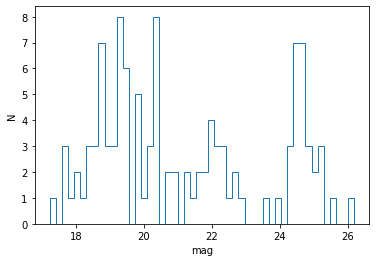

In [8]:
import matplotlib.pyplot as plt

plt.hist(totmag.value, bins=50, histtype='step')
plt.xlabel('mag')
plt.ylabel('N')
plt.show()

The magnitudes appear to be in the expected range of 17 < mag < 26, so it's likely that the units in the table are in fact nJy. Nonetheless, the lack of units prevents us from signing off on this requirement. For now, we classify this test result as an **initial pass**, and future campaigns will re-assess the Object table(s) to confirm that units are provided.